<a href="https://colab.research.google.com/github/jaya01092005/HIV-Drug-Resistance-Prediction/blob/main/NRTI_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io

In [ ]:
class HIVDrugResistanceDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            sequences,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
            add_special_tokens=True
        )
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def process_resistance_data(df):
    """
    Enhanced data processing with handling for rare classes
    """
    sequences = []
    for _, row in df.iterrows():
        # Extract mutation list from the last column
        mutation_pattern = row['CompMutList']

        if pd.isna(mutation_pattern) or mutation_pattern == '-':
            sequences.append("WILDTYPE NO_MUTATIONS SUSCEPTIBLE")
        else:
            mutations = mutation_pattern.split(", ")
            mutations = [f"RT_{mut}" for mut in mutations]
            mutations_with_context = []
            for mut in mutations:
                position = ''.join(filter(str.isdigit, mut))
                mutations_with_context.append(f"{mut} POS_{position}")
            sequences.append(" ".join(mutations_with_context))

    # Define drugs based on the columns in the dataset
    drugs = ['AZT', 'TDF', 'ABC', '3TC']
    labels = []
    valid_samples_mask = []  # Track which samples to keep

    # First pass to count classes for each drug
    drug_class_counts = {drug: {0: 0, 1: 0} for drug in drugs}
    for _, row in df.iterrows():
        for drug in drugs:
            if pd.isna(row[drug]) or row[drug] == 'NA':
                drug_class_counts[drug][0] += 1
            else:
                fold_value = float(row[drug])
                label = 1 if fold_value > 3.5 else 0
                drug_class_counts[drug][label] += 1

    # Print class distribution before filtering
    print("Class distribution before filtering:")
    for drug in drugs:
        print(f"\n{drug}:")
        print(f"Class 0 (non-resistant): {drug_class_counts[drug][0]}")
        print(f"Class 1 (resistant): {drug_class_counts[drug][1]}")

    # Second pass to create labels, excluding samples with rare classes
    for _, row in df.iterrows():
        drug_labels = []
        valid_sample = True

        for drug in drugs:
            if pd.isna(row[drug]) or row[drug] == 'NA':
                label = 0
            else:
                fold_value = float(row[drug])
                label = 1 if fold_value > 3.5 else 0

            # Check if this class is rare for this drug
            #if drug_class_counts[drug][label] < 2:
                #valid_sample = False
                #break

            drug_labels.append(label)


        labels.append(drug_labels)
        valid_samples_mask.append(True)


    # Filter sequences to match valid labels
    sequences = [seq for seq, mask in zip(sequences, valid_samples_mask) if mask]

    # Print final class distribution
    print("\nClass distribution after filtering rare classes:")
    filtered_df = df[valid_samples_mask]
    for drug in drugs:
        resistant_count = sum(1 for _, row in filtered_df.iterrows()
                            if not pd.isna(row[drug]) and row[drug] != 'NA' and float(row[drug]) > 10)
        non_resistant_count = len(filtered_df) - resistant_count
        print(f"\n{drug}:")
        print(f"Class 0 (non-resistant): {non_resistant_count}")
        print(f"Class 1 (resistant): {resistant_count}")

    return sequences, labels

In [ ]:
def upload_and_process_file():
    """
    Handle file upload in Google Colab and process the data
    """
    print("Please upload your resistance data file...")
    uploaded = files.upload()

    file_name = list(uploaded.keys())[0]
    content = uploaded[file_name]

    if file_name.endswith('.txt'):
        df = pd.read_csv(io.BytesIO(content), sep='\t')
    else:
        raise ValueError("Please upload a tab-separated txt file")

    return df

In [ ]:
def calculate_metrics(predictions, true_labels):
    """
    Calculate various metrics for model evaluation
    """
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels.flatten(), predictions.flatten(), average="binary")
    accuracy = accuracy_score(true_labels.flatten(), predictions.flatten())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels.flatten(), predictions.flatten())
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "specificity": specificity,
        "npv": npv,
        "confusion_matrix": {
            "true_positives": int(tp),
            "true_negatives": int(tn),
            "false_positives": int(fp),
            "false_negatives": int(fn)
        }
    }

    return metrics, conf_matrix

In [ ]:
def plot_confusion_matrix(conf_matrix):
    """
    Plot a confusion matrix as a heatmap
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Negative", "Predicted Positive"],
        yticklabels=["Actual Negative", "Actual Positive"]
    )
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def print_metrics(metrics):
    """
    Print formatted metrics and confusion matrix elements
    """
    print("\nValidation Metrics:")
    print("-" * 40)

    for metric, value in metrics.items():
        if metric != "confusion_matrix":
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    print("\nConfusion Matrix Elements:")
    for key, value in metrics["confusion_matrix"].items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    print("-" * 40)

In [ ]:
def get_warmup_steps(config, num_training_steps):
    """Calculate warmup steps based on either direct steps or ratio"""
    if 'warmup_steps' in config:
        return config['warmup_steps']
    elif 'warmup_ratio' in config:
        return int(num_training_steps * config['warmup_ratio'])
    else:
        # Default to 10% if neither is specified
        return int(num_training_steps * 0.1)

In [ ]:
def train_model(train_dataset, val_dataset, model, device, config):
    """
    Enhanced training function with better optimization and monitoring
    """
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

    # Initialize optimizer with weight decay
    optimizer = AdamW(model.parameters(),
                     lr=config['learning_rate'],
                     weight_decay=config['weight_decay'])

    # Calculate total training steps and warmup steps
    num_training_steps = len(train_loader) * config['num_epochs']
    warmup_steps = get_warmup_steps(config, num_training_steps)

    print(f"Total training steps: {num_training_steps}")
    print(f"Warmup steps: {warmup_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )

    best_val_loss = float("inf")
    patience = config['patience']
    patience_counter = 0
    training_stats = []

    for epoch in range(config['num_epochs']):
        model.train()
        total_loss = 0
        steps = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Add L1 regularization if specified
            if 'l1_lambda' in config:
                l1_lambda = config['l1_lambda']
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            total_loss += loss.item()
            steps += 1

            loss.backward()

            # Gradient clipping
            if 'max_grad_norm' in config:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / steps

        # Validation phase
        model.eval()
        val_loss = 0
        y_true_all, y_scores_all = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                logits = outputs.logits
                probabilities = torch.sigmoid(logits).cpu().numpy()
                y_scores_all.extend(probabilities)
                y_true_all.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)

        # Generate PR Curves for Each Drug
        y_true_all = np.array(y_true_all)
        y_scores_all = np.array(y_scores_all)
        num_drugs = y_true_all.shape[1]


        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        for i in range(num_drugs):
            precision, recall, _ = precision_recall_curve(y_true_all[:, i], y_scores_all[:, i])
            pr_auc = auc(recall, precision)
            plt.figure()
            plt.plot(recall, precision, color=colors[i % len(colors)])
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve for Drug {i + 1}")
            #plt.legend()
            plt.grid(False)
            plt.show()

            print(f"PR-AUC for Drug {i + 1}: {pr_auc:.4f}")

        # Calculate and print metrics
        predictions = (np.array(y_scores_all) > 0.5).astype(int)
        metrics, conf_matrix = calculate_metrics(predictions, y_true_all)
        current_lr = scheduler.get_last_lr()[0]

        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        print_metrics(metrics)
        plot_confusion_matrix(conf_matrix)

        # Save training stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'learning_rate': current_lr,
            **metrics
        })

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            model.save_pretrained("best_hiv_resistance_model")
            print("Saved best model!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return model, training_stats

Using device: cuda
Loading model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please upload your resistance data file...


Saving NRTI_DataSet.txt to NRTI_DataSet (1).txt
Class distribution before filtering:

AZT:
Class 0 (non-resistant): 1212
Class 1 (resistant): 955

TDF:
Class 0 (non-resistant): 2010
Class 1 (resistant): 157

ABC:
Class 0 (non-resistant): 1168
Class 1 (resistant): 999

3TC:
Class 0 (non-resistant): 829
Class 1 (resistant): 1338

Class distribution after filtering rare classes:

AZT:
Class 0 (non-resistant): 1476
Class 1 (resistant): 691

TDF:
Class 0 (non-resistant): 2144
Class 1 (resistant): 23

ABC:
Class 0 (non-resistant): 2032
Class 1 (resistant): 135

3TC:
Class 0 (non-resistant): 1061
Class 1 (resistant): 1106


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total training steps: 4340
Warmup steps: 651


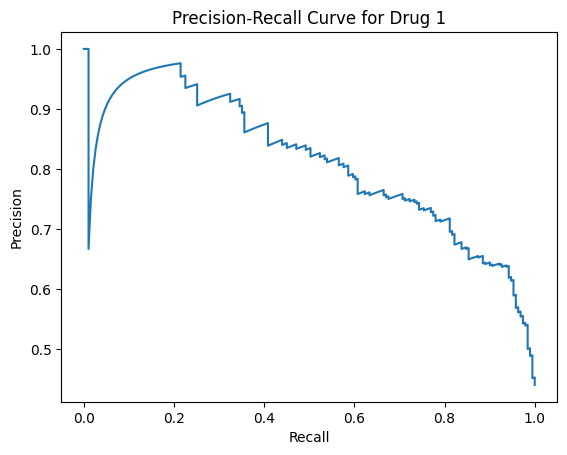

PR-AUC for Drug 1: 0.8098


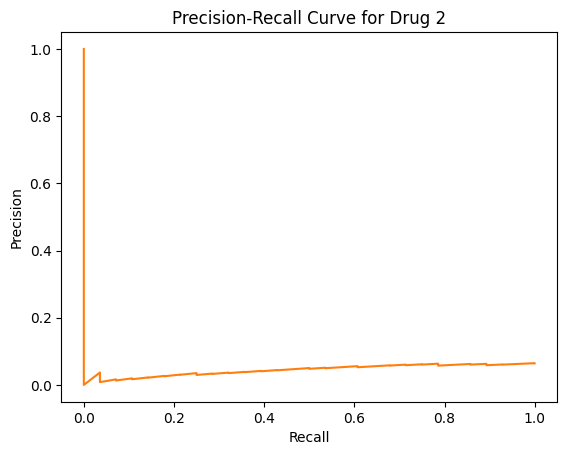

PR-AUC for Drug 2: 0.0445


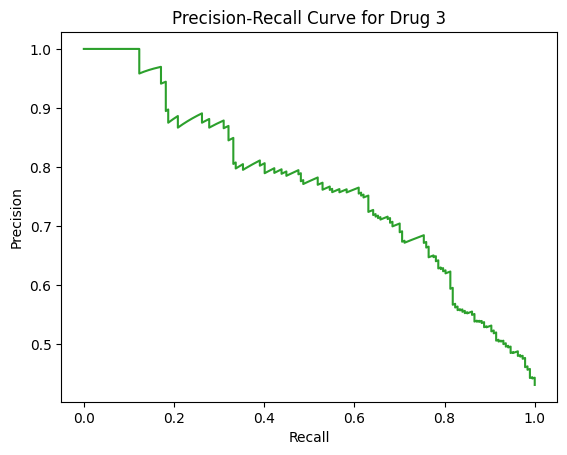

PR-AUC for Drug 3: 0.7648


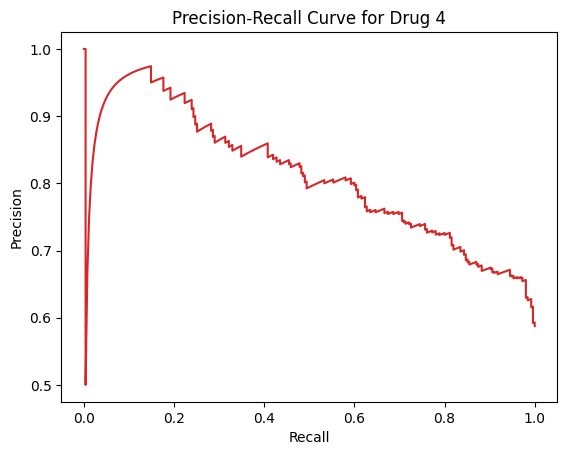

PR-AUC for Drug 4: 0.8086

Epoch 1/20
Training Loss: 0.6226
Validation Loss: 0.5061
Learning Rate: 3.33e-06

Validation Metrics:
----------------------------------------
Precision: 0.7631
Recall: 0.5749
F1 Score: 0.6557
Accuracy: 0.7702
Specificity: 0.8902
Npv: 0.7730

Confusion Matrix Elements:
True Positives: 380
True Negatives: 957
False Positives: 118
False Negatives: 281
----------------------------------------


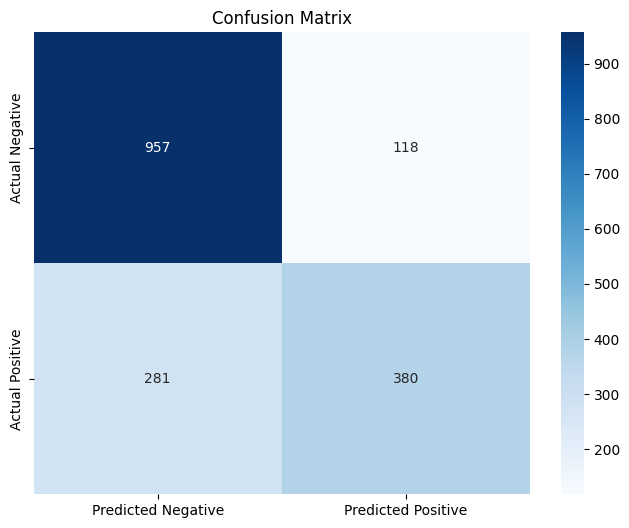

Saved best model!


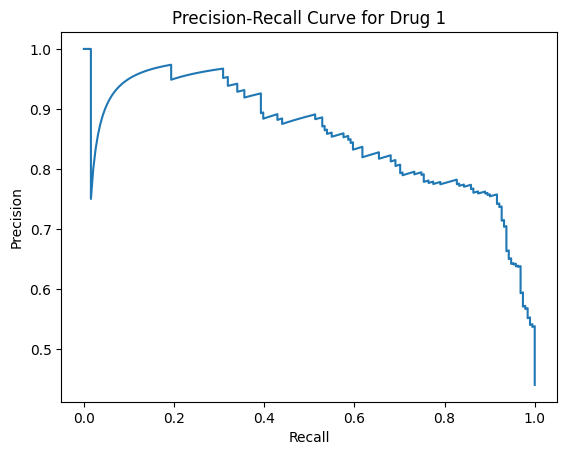

PR-AUC for Drug 1: 0.8549


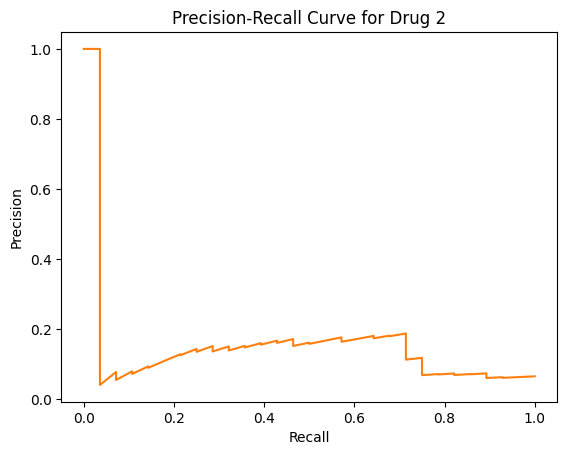

PR-AUC for Drug 2: 0.1516


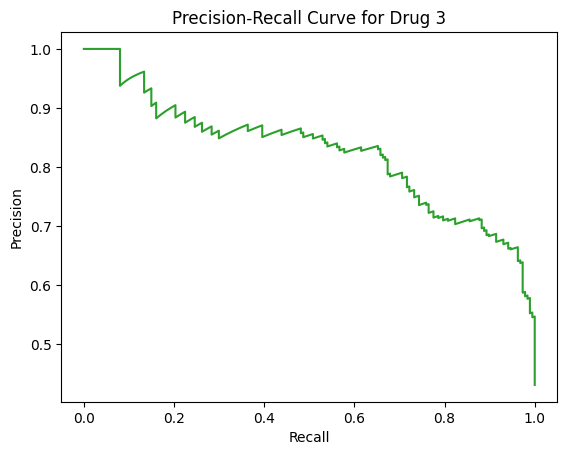

PR-AUC for Drug 3: 0.8252


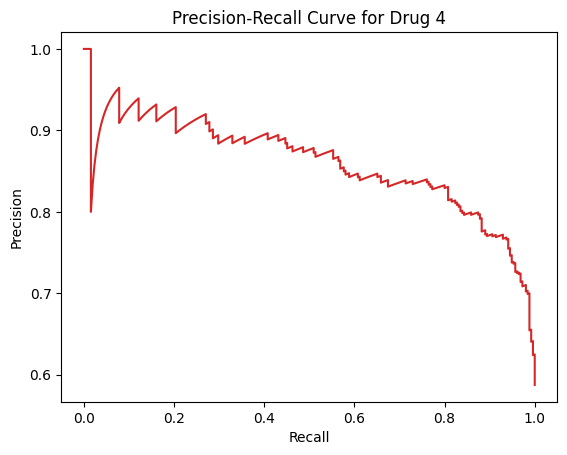

PR-AUC for Drug 4: 0.8601

Epoch 2/20
Training Loss: 0.4775
Validation Loss: 0.4083
Learning Rate: 6.67e-06

Validation Metrics:
----------------------------------------
Precision: 0.7973
Recall: 0.7201
F1 Score: 0.7568
Accuracy: 0.8237
Specificity: 0.8874
Npv: 0.8376

Confusion Matrix Elements:
True Positives: 476
True Negatives: 954
False Positives: 121
False Negatives: 185
----------------------------------------


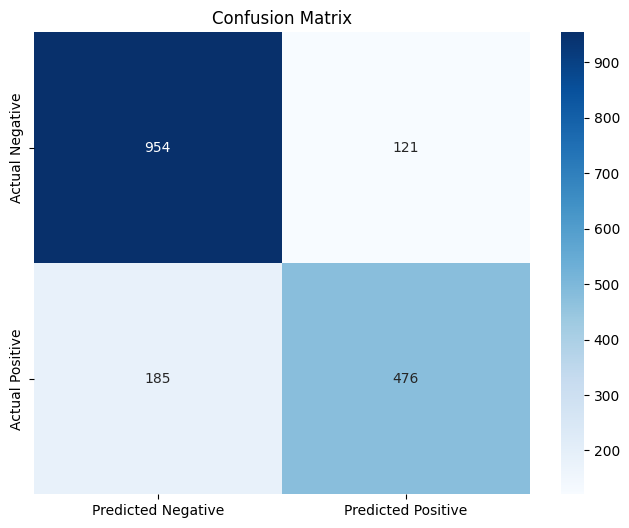

Saved best model!


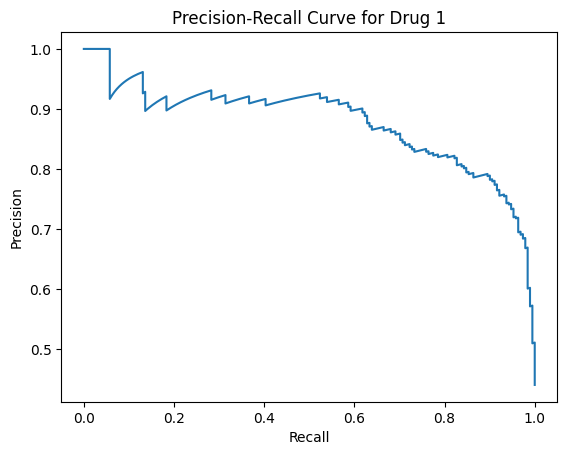

PR-AUC for Drug 1: 0.8776


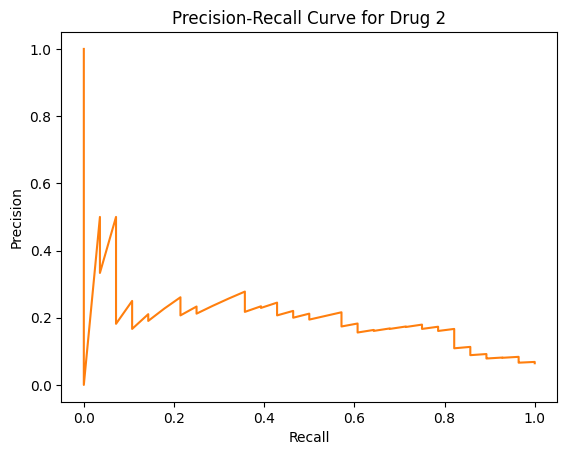

PR-AUC for Drug 2: 0.1924


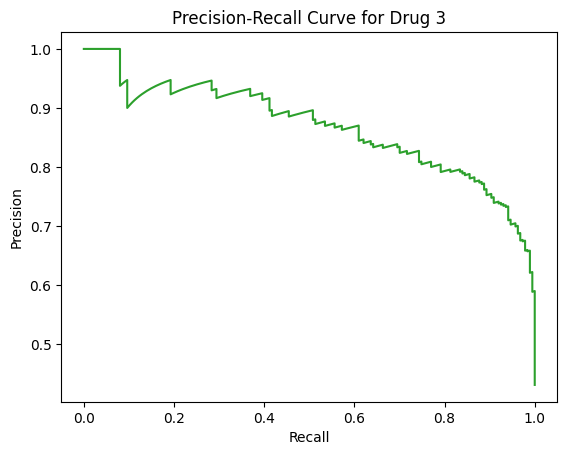

PR-AUC for Drug 3: 0.8679


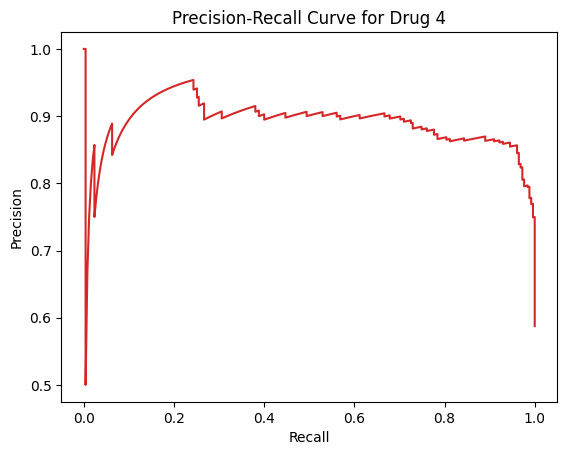

PR-AUC for Drug 4: 0.8883

Epoch 3/20
Training Loss: 0.4125
Validation Loss: 0.3368
Learning Rate: 1.00e-05

Validation Metrics:
----------------------------------------
Precision: 0.7995
Recall: 0.8805
F1 Score: 0.8380
Accuracy: 0.8704
Specificity: 0.8642
Npv: 0.9216

Confusion Matrix Elements:
True Positives: 582
True Negatives: 929
False Positives: 146
False Negatives: 79
----------------------------------------


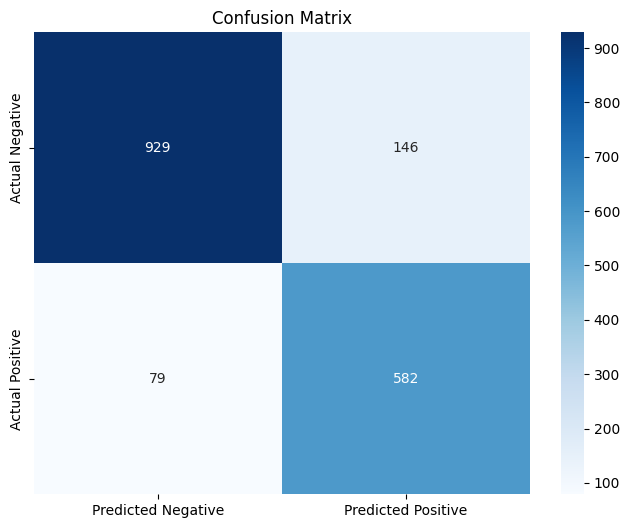

Saved best model!


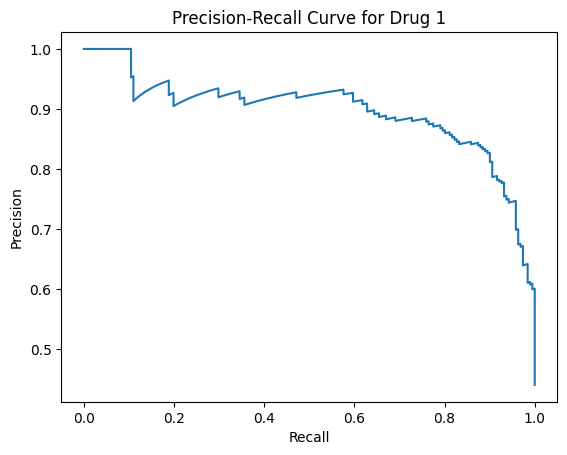

PR-AUC for Drug 1: 0.8959


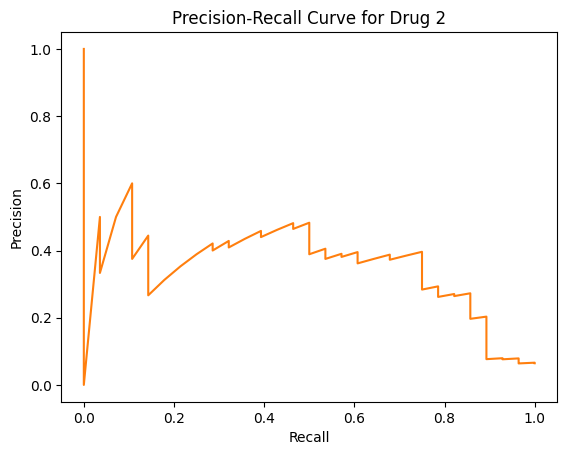

PR-AUC for Drug 2: 0.3441


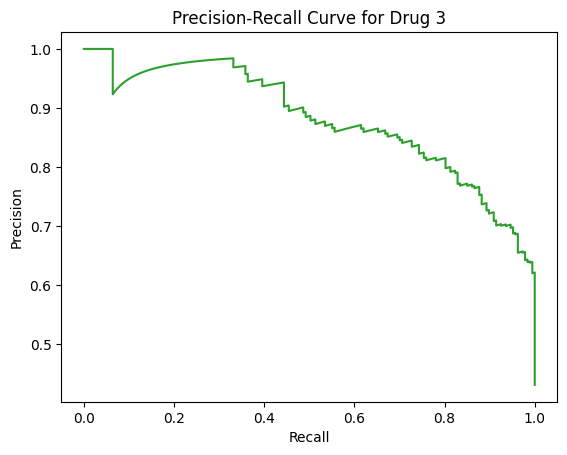

PR-AUC for Drug 3: 0.8808


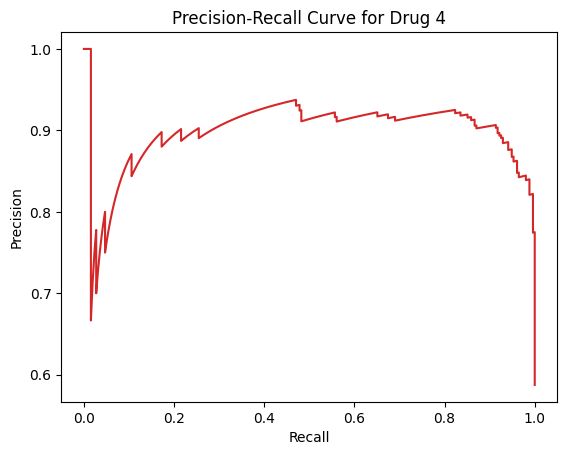

PR-AUC for Drug 4: 0.8978

Epoch 4/20
Training Loss: 0.3439
Validation Loss: 0.3334
Learning Rate: 9.41e-06

Validation Metrics:
----------------------------------------
Precision: 0.8554
Recall: 0.7337
F1 Score: 0.7899
Accuracy: 0.8514
Specificity: 0.9237
Npv: 0.8494

Confusion Matrix Elements:
True Positives: 485
True Negatives: 993
False Positives: 82
False Negatives: 176
----------------------------------------


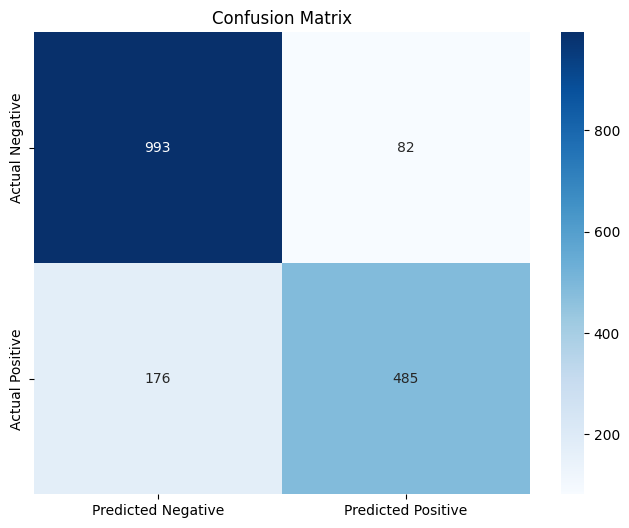

Saved best model!


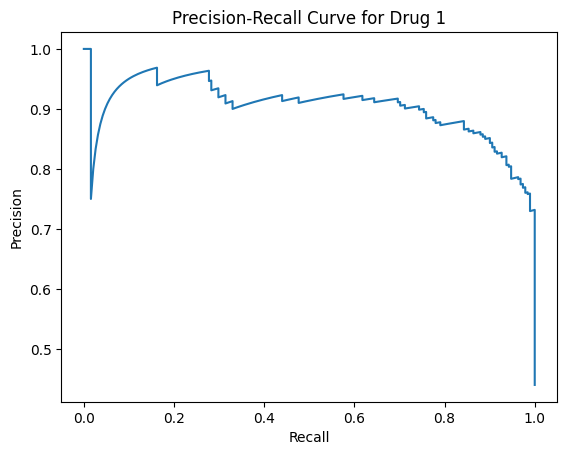

PR-AUC for Drug 1: 0.9039


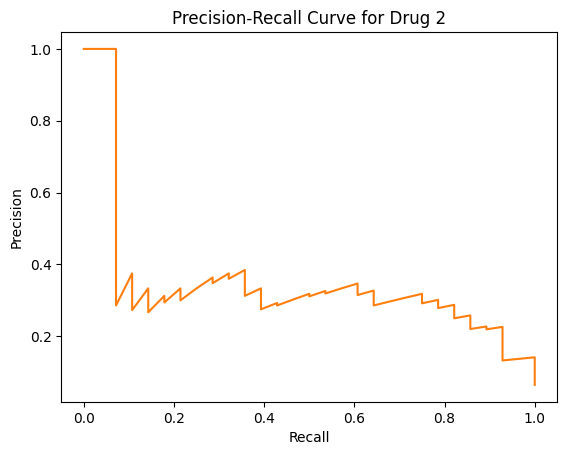

PR-AUC for Drug 2: 0.3433


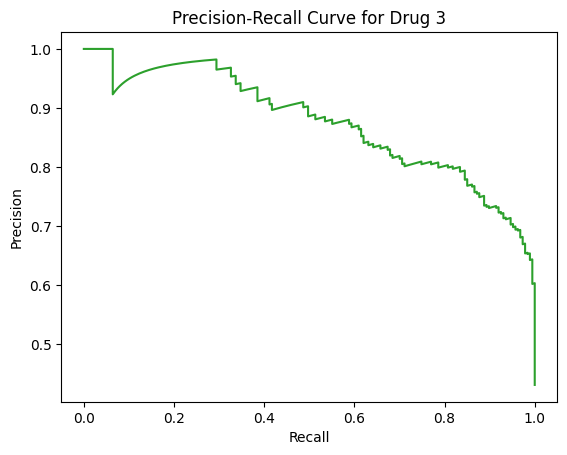

PR-AUC for Drug 3: 0.8757


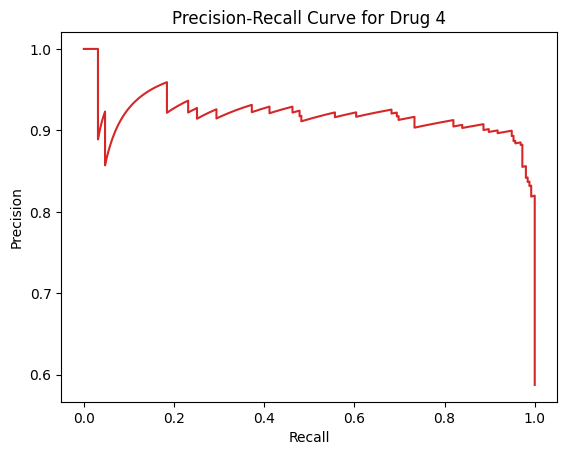

PR-AUC for Drug 4: 0.9181

Epoch 5/20
Training Loss: 0.3094
Validation Loss: 0.3239
Learning Rate: 8.82e-06

Validation Metrics:
----------------------------------------
Precision: 0.7488
Recall: 0.9425
F1 Score: 0.8346
Accuracy: 0.8577
Specificity: 0.8056
Npv: 0.9580

Confusion Matrix Elements:
True Positives: 623
True Negatives: 866
False Positives: 209
False Negatives: 38
----------------------------------------


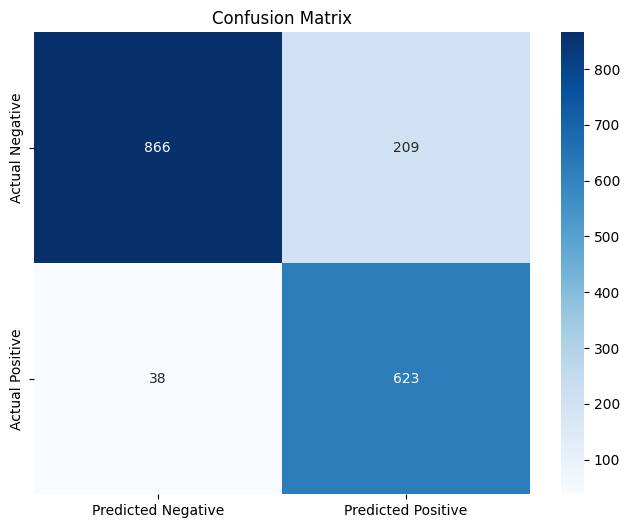

Saved best model!


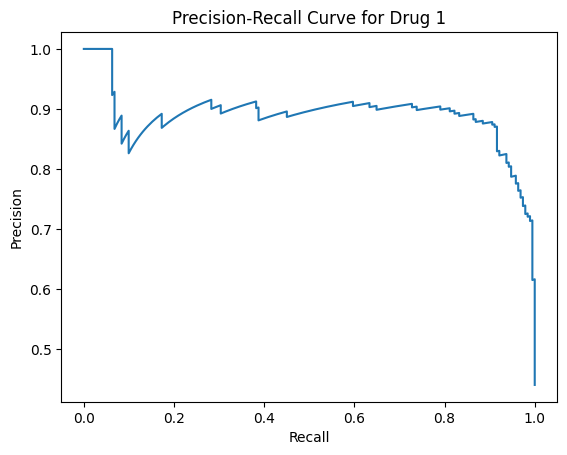

PR-AUC for Drug 1: 0.8900


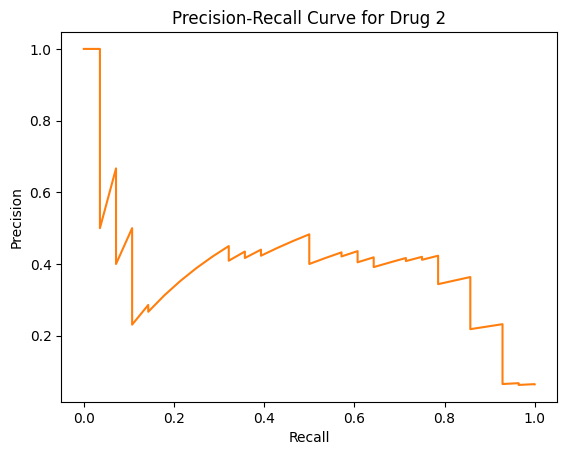

PR-AUC for Drug 2: 0.3906


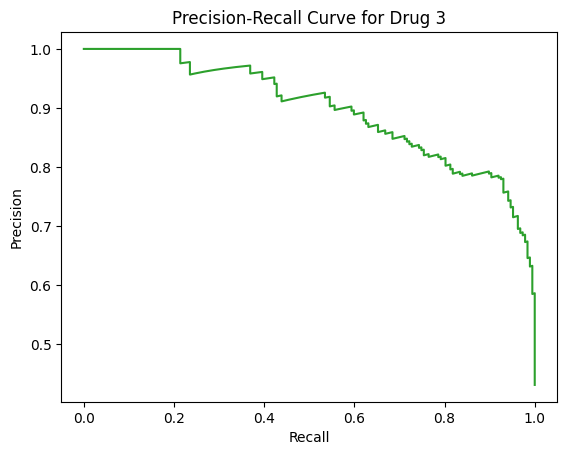

PR-AUC for Drug 3: 0.8983


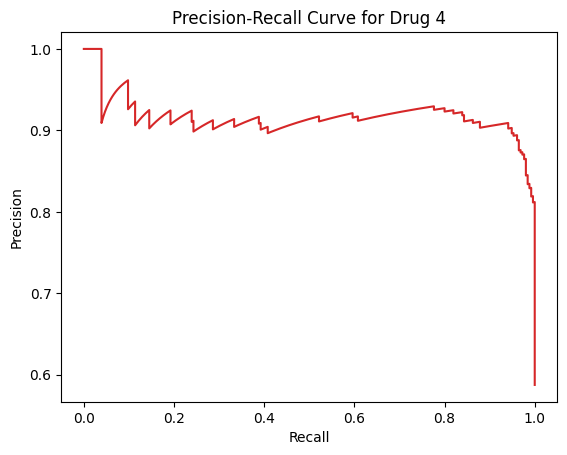

PR-AUC for Drug 4: 0.9165

Epoch 6/20
Training Loss: 0.2877
Validation Loss: 0.2741
Learning Rate: 8.24e-06

Validation Metrics:
----------------------------------------
Precision: 0.8625
Recall: 0.8351
F1 Score: 0.8486
Accuracy: 0.8865
Specificity: 0.9181
Npv: 0.9005

Confusion Matrix Elements:
True Positives: 552
True Negatives: 987
False Positives: 88
False Negatives: 109
----------------------------------------


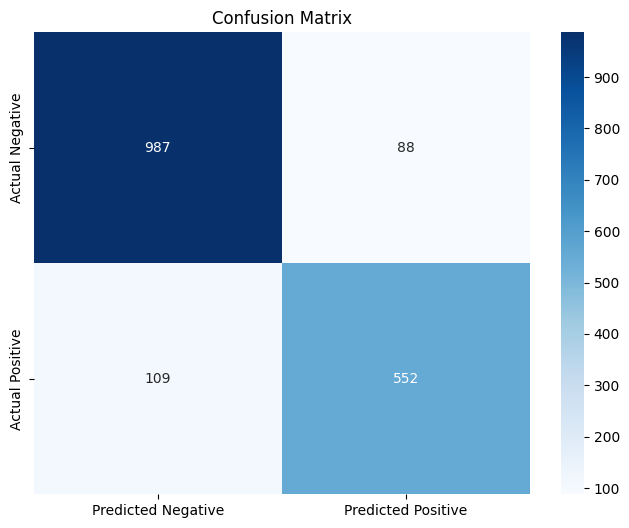

Saved best model!


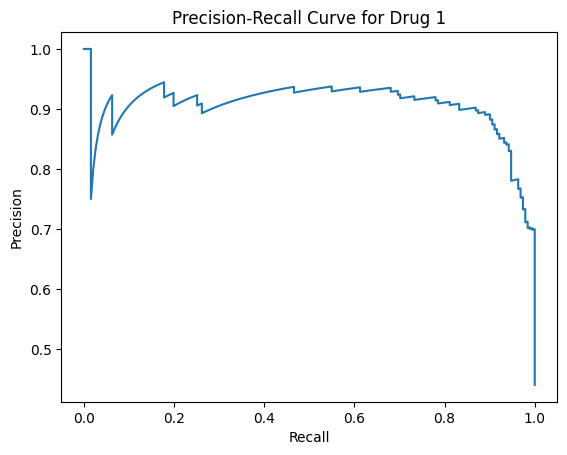

PR-AUC for Drug 1: 0.9057


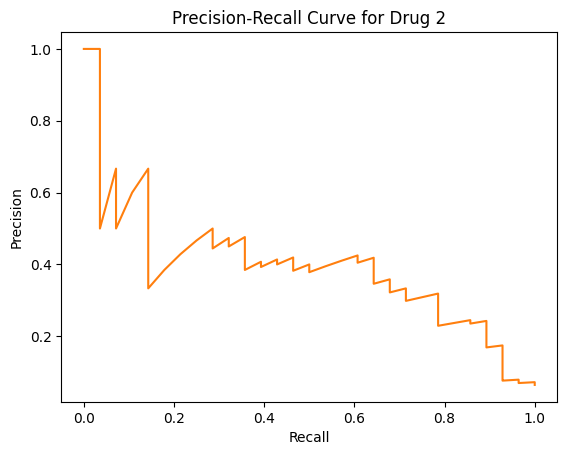

PR-AUC for Drug 2: 0.3905


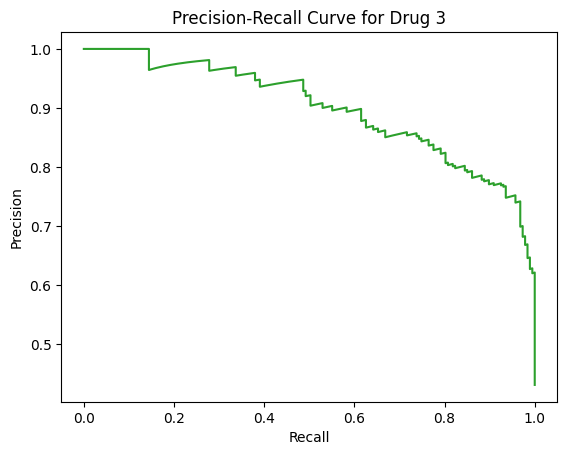

PR-AUC for Drug 3: 0.8989


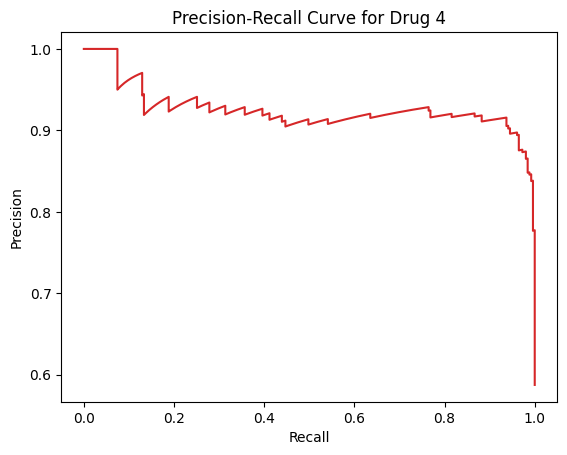

PR-AUC for Drug 4: 0.9257

Epoch 7/20
Training Loss: 0.2713
Validation Loss: 0.2758
Learning Rate: 7.65e-06

Validation Metrics:
----------------------------------------
Precision: 0.8594
Recall: 0.8411
F1 Score: 0.8502
Accuracy: 0.8871
Specificity: 0.9153
Npv: 0.9036

Confusion Matrix Elements:
True Positives: 556
True Negatives: 984
False Positives: 91
False Negatives: 105
----------------------------------------


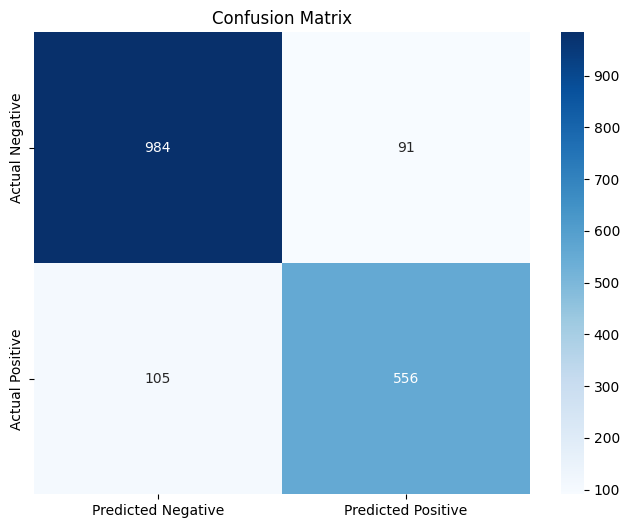

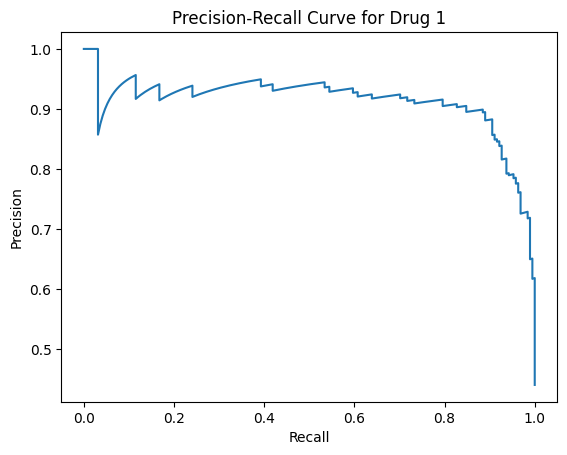

PR-AUC for Drug 1: 0.9133


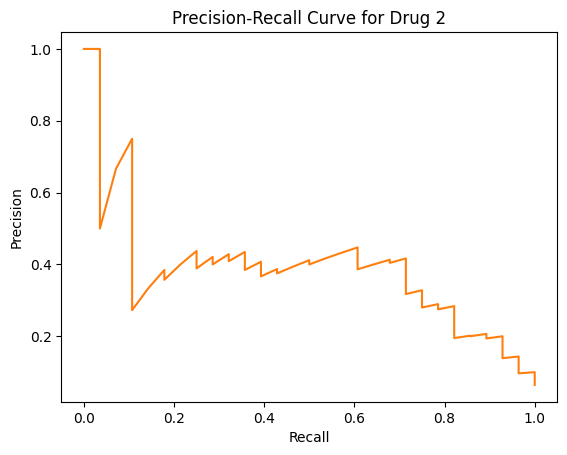

PR-AUC for Drug 2: 0.3843


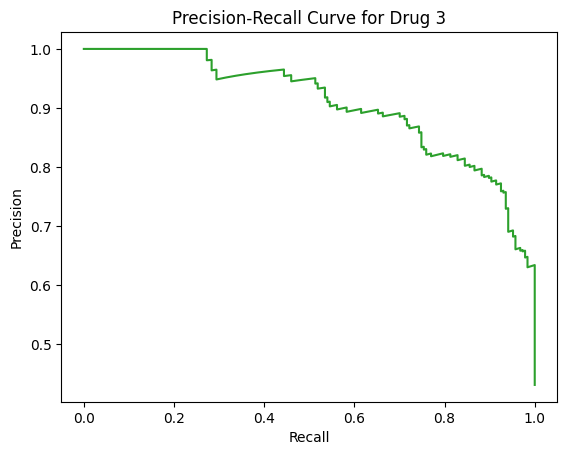

PR-AUC for Drug 3: 0.9065


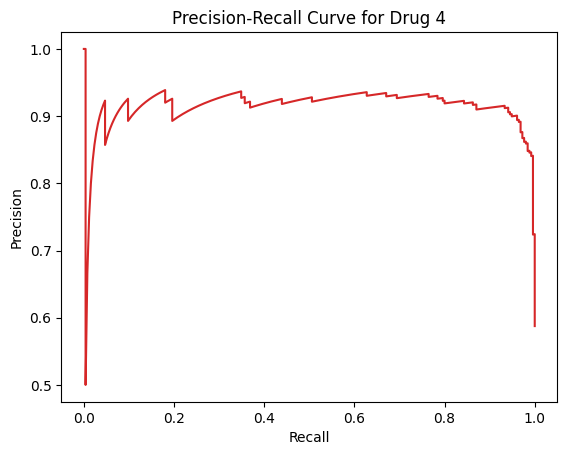

PR-AUC for Drug 4: 0.9146

Epoch 8/20
Training Loss: 0.2569
Validation Loss: 0.2686
Learning Rate: 7.06e-06

Validation Metrics:
----------------------------------------
Precision: 0.8340
Recall: 0.9047
F1 Score: 0.8679
Accuracy: 0.8952
Specificity: 0.8893
Npv: 0.9382

Confusion Matrix Elements:
True Positives: 598
True Negatives: 956
False Positives: 119
False Negatives: 63
----------------------------------------


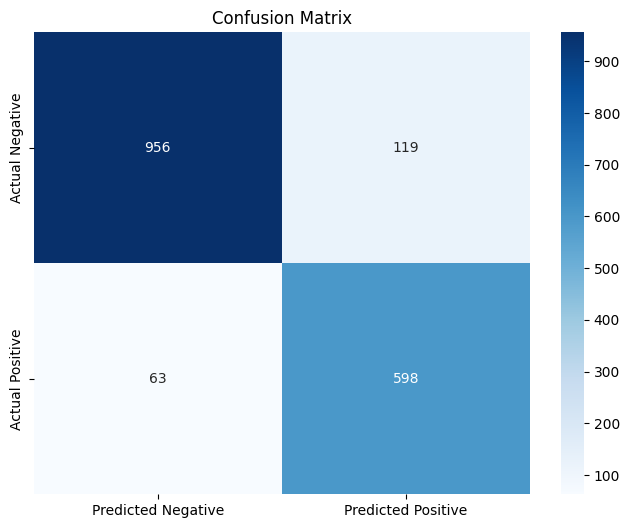

Saved best model!


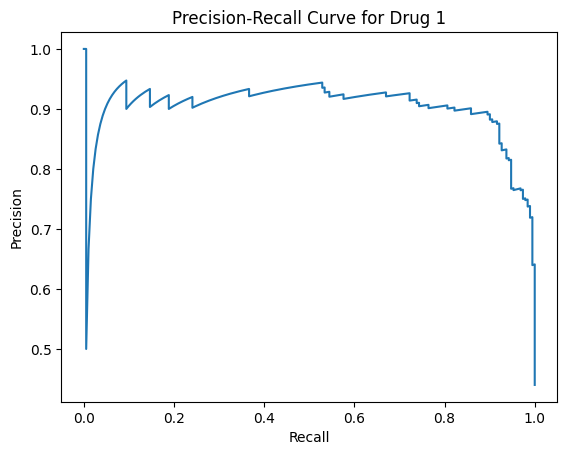

PR-AUC for Drug 1: 0.9018


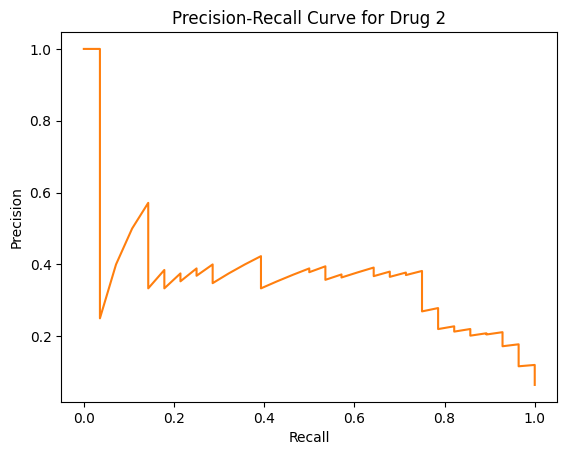

PR-AUC for Drug 2: 0.3598


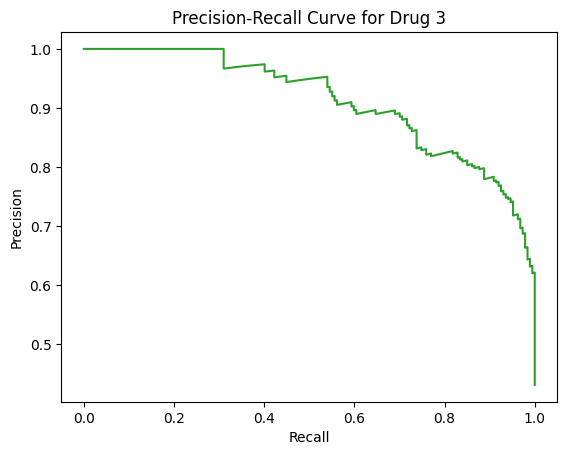

PR-AUC for Drug 3: 0.9119


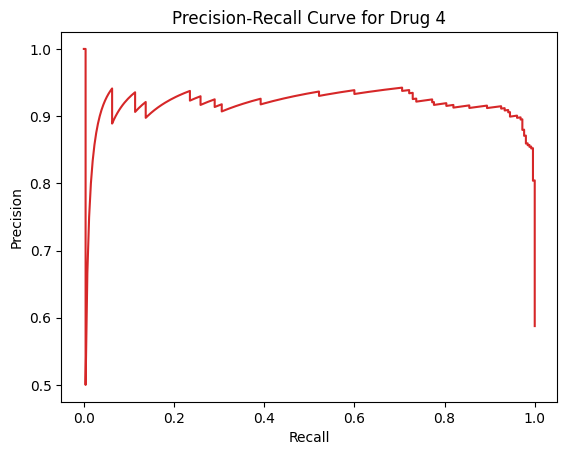

PR-AUC for Drug 4: 0.9174

Epoch 9/20
Training Loss: 0.2444
Validation Loss: 0.2765
Learning Rate: 6.47e-06

Validation Metrics:
----------------------------------------
Precision: 0.8045
Recall: 0.9274
F1 Score: 0.8616
Accuracy: 0.8865
Specificity: 0.8614
Npv: 0.9507

Confusion Matrix Elements:
True Positives: 613
True Negatives: 926
False Positives: 149
False Negatives: 48
----------------------------------------


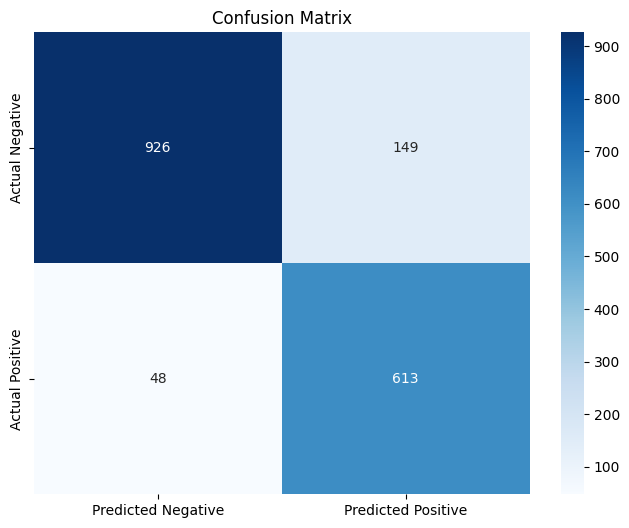

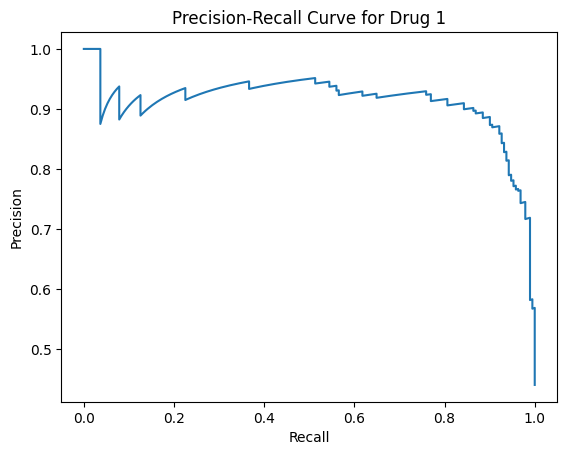

PR-AUC for Drug 1: 0.9125


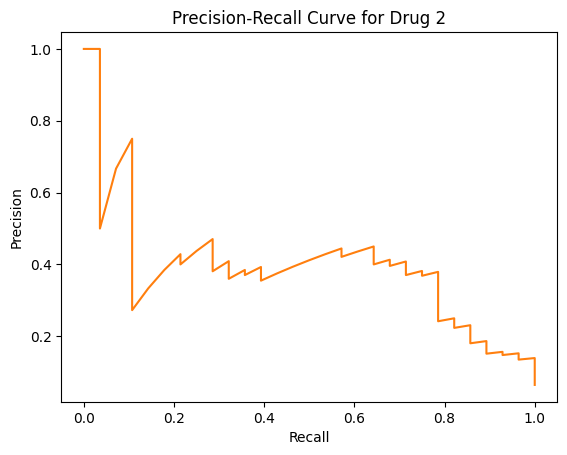

PR-AUC for Drug 2: 0.3900


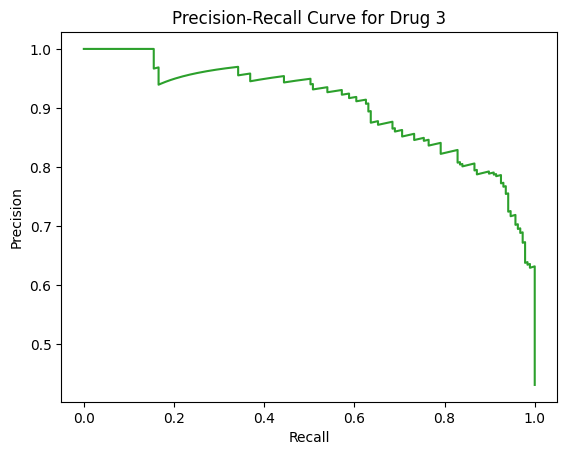

PR-AUC for Drug 3: 0.9029


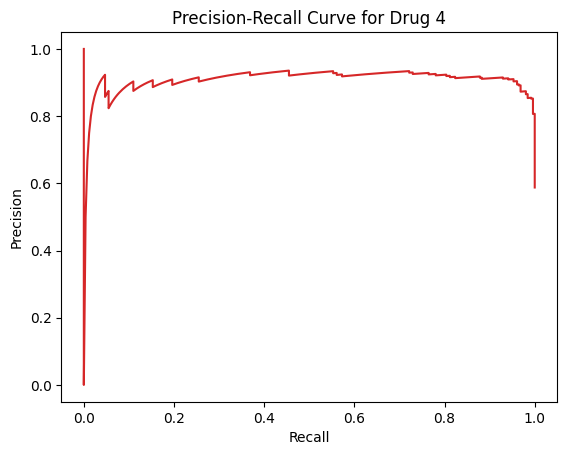

PR-AUC for Drug 4: 0.9070

Epoch 10/20
Training Loss: 0.2366
Validation Loss: 0.2620
Learning Rate: 5.88e-06

Validation Metrics:
----------------------------------------
Precision: 0.8529
Recall: 0.8775
F1 Score: 0.8650
Accuracy: 0.8957
Specificity: 0.9070
Npv: 0.9233

Confusion Matrix Elements:
True Positives: 580
True Negatives: 975
False Positives: 100
False Negatives: 81
----------------------------------------


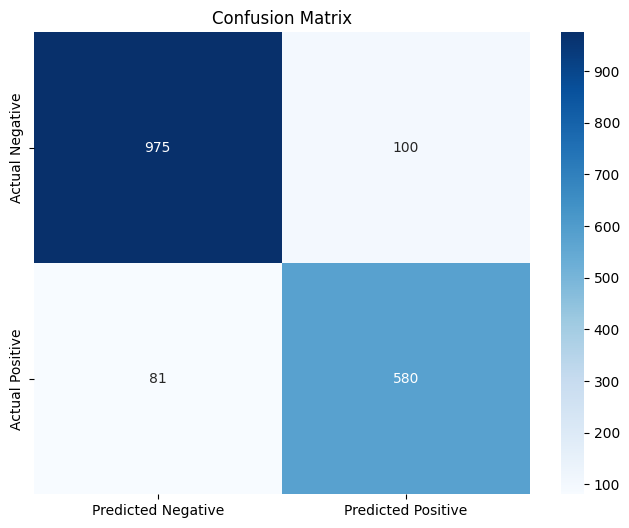

Saved best model!


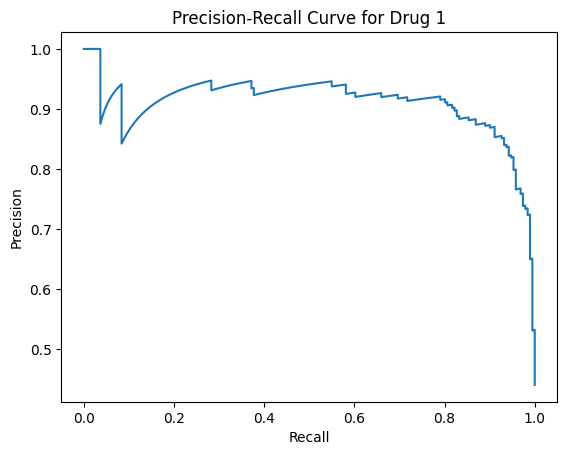

PR-AUC for Drug 1: 0.9100


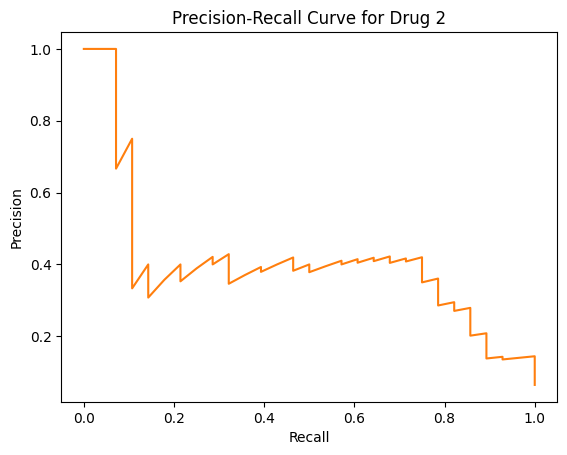

PR-AUC for Drug 2: 0.4036


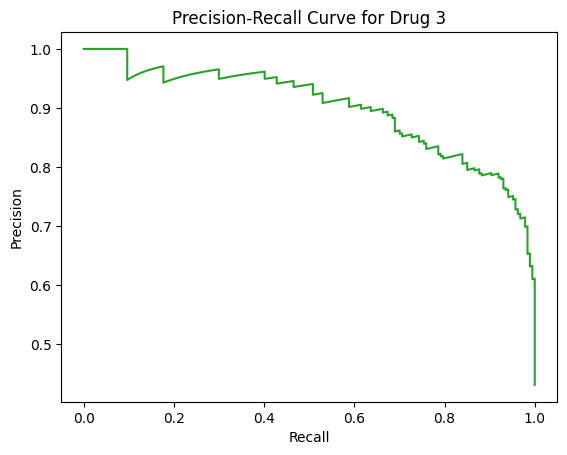

PR-AUC for Drug 3: 0.9002


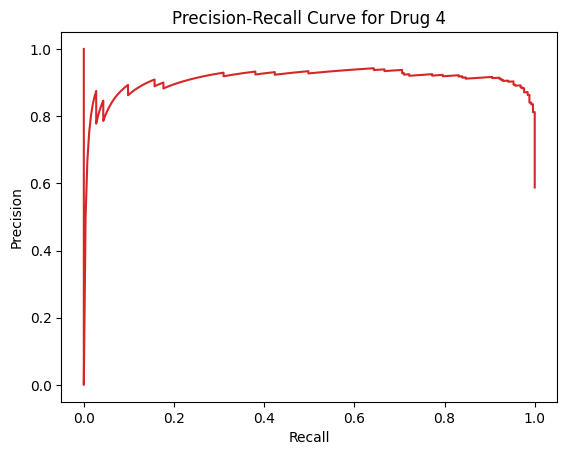

PR-AUC for Drug 4: 0.9062

Epoch 11/20
Training Loss: 0.2279
Validation Loss: 0.2674
Learning Rate: 5.29e-06

Validation Metrics:
----------------------------------------
Precision: 0.8273
Recall: 0.9062
F1 Score: 0.8650
Accuracy: 0.8923
Specificity: 0.8837
Npv: 0.9387

Confusion Matrix Elements:
True Positives: 599
True Negatives: 950
False Positives: 125
False Negatives: 62
----------------------------------------


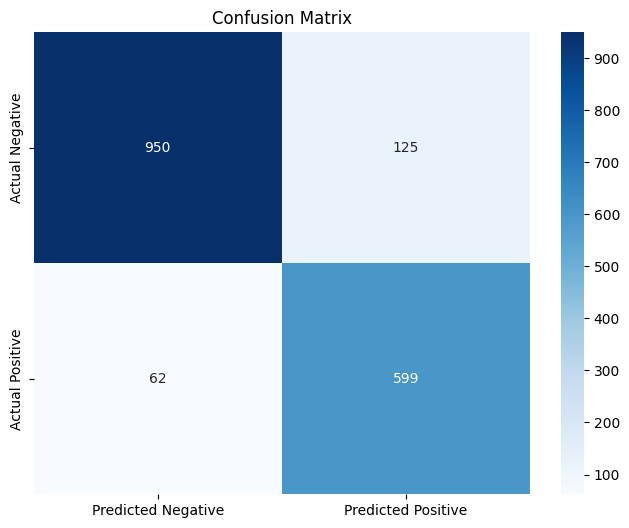

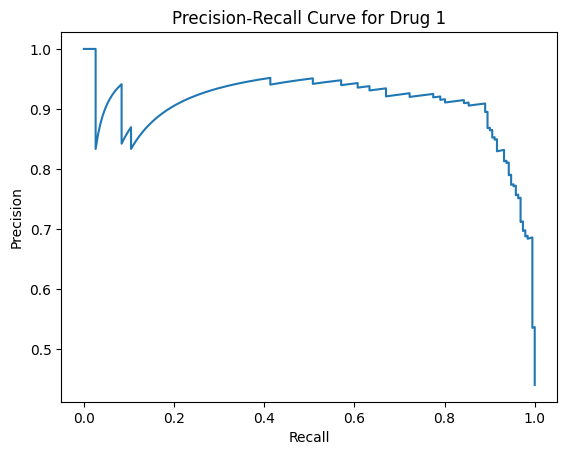

PR-AUC for Drug 1: 0.9079


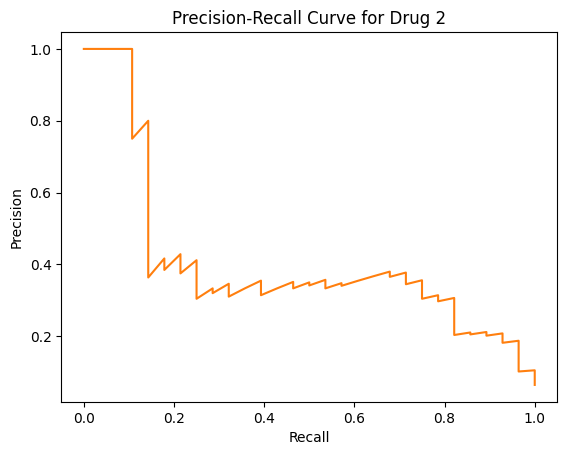

PR-AUC for Drug 2: 0.4037


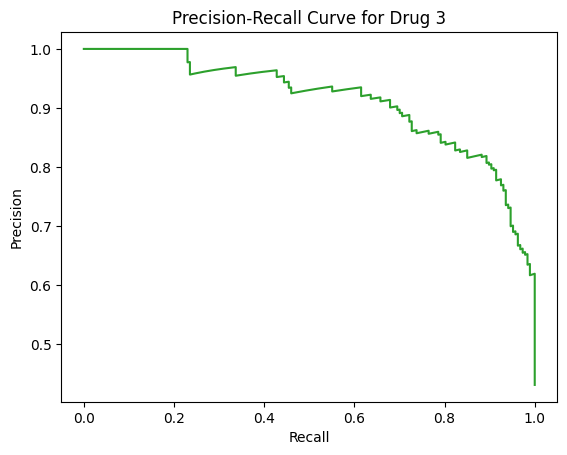

PR-AUC for Drug 3: 0.9128


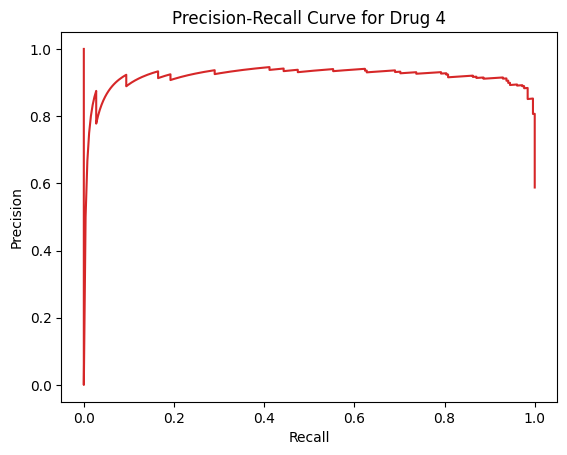

PR-AUC for Drug 4: 0.9151

Epoch 12/20
Training Loss: 0.2205
Validation Loss: 0.2722
Learning Rate: 4.71e-06

Validation Metrics:
----------------------------------------
Precision: 0.8336
Recall: 0.8941
F1 Score: 0.8628
Accuracy: 0.8917
Specificity: 0.8902
Npv: 0.9318

Confusion Matrix Elements:
True Positives: 591
True Negatives: 957
False Positives: 118
False Negatives: 70
----------------------------------------


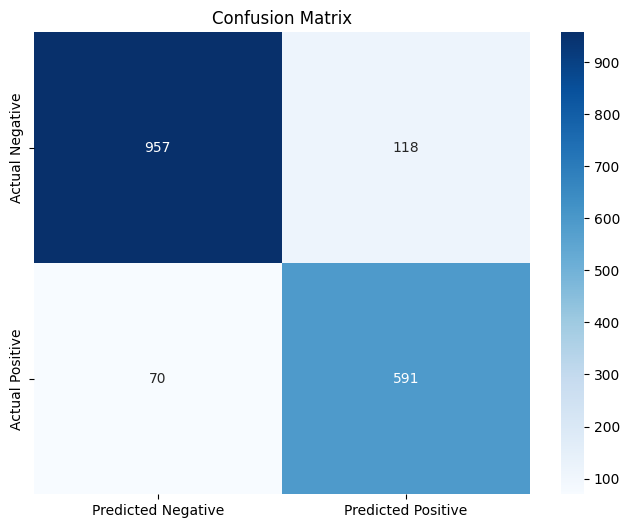

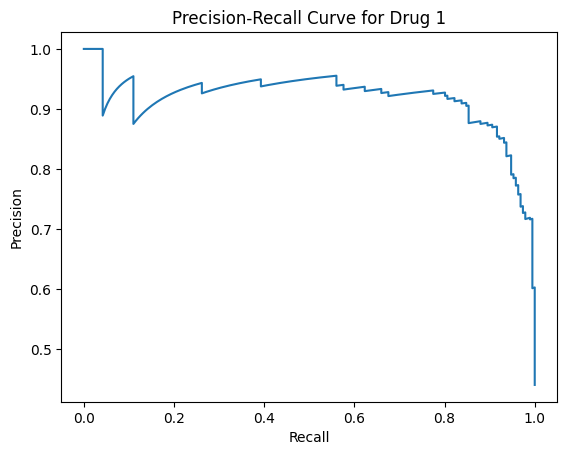

PR-AUC for Drug 1: 0.9178


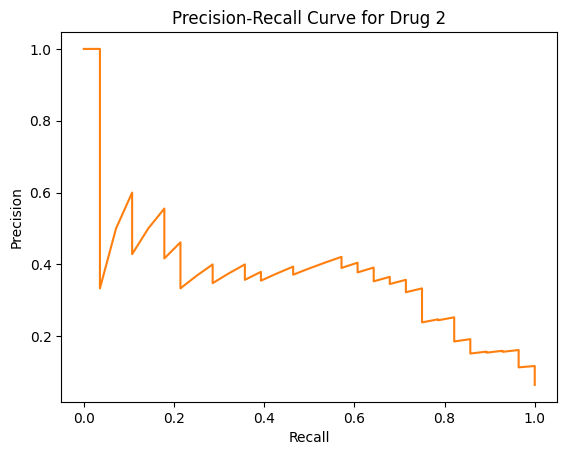

PR-AUC for Drug 2: 0.3670


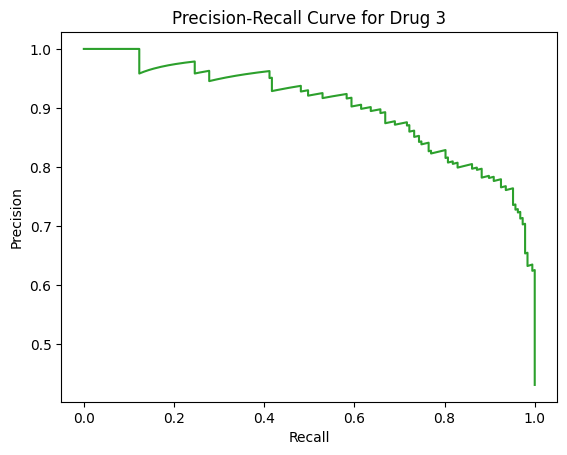

PR-AUC for Drug 3: 0.9018


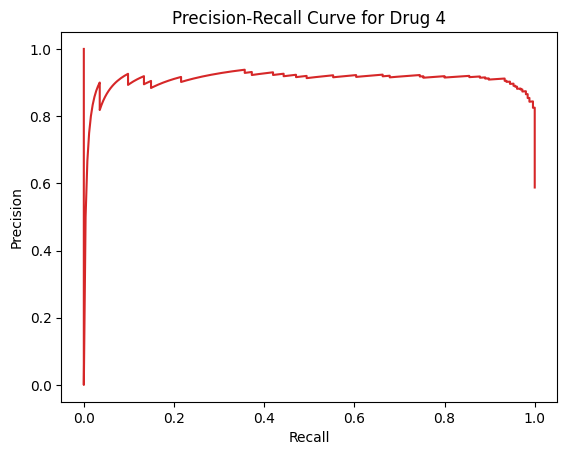

PR-AUC for Drug 4: 0.9064

Epoch 13/20
Training Loss: 0.2112
Validation Loss: 0.2704
Learning Rate: 4.12e-06

Validation Metrics:
----------------------------------------
Precision: 0.8331
Recall: 0.8986
F1 Score: 0.8646
Accuracy: 0.8929
Specificity: 0.8893
Npv: 0.9345

Confusion Matrix Elements:
True Positives: 594
True Negatives: 956
False Positives: 119
False Negatives: 67
----------------------------------------


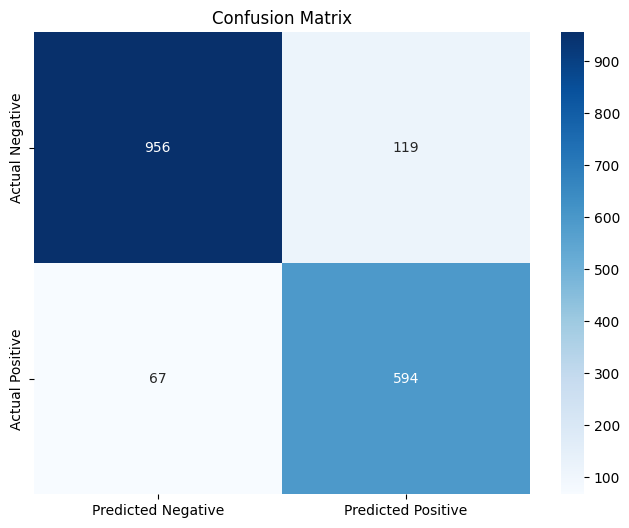

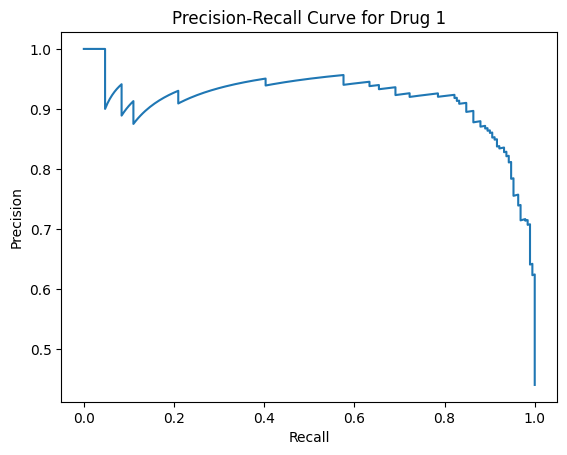

PR-AUC for Drug 1: 0.9156


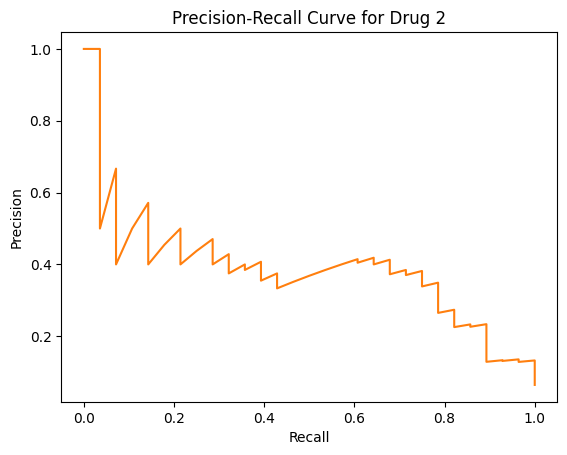

PR-AUC for Drug 2: 0.3867


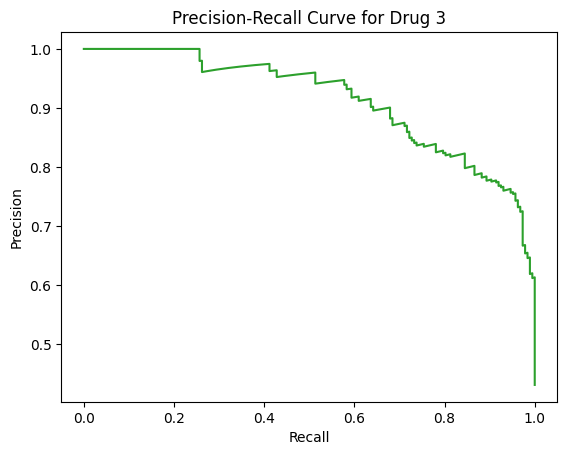

PR-AUC for Drug 3: 0.9132


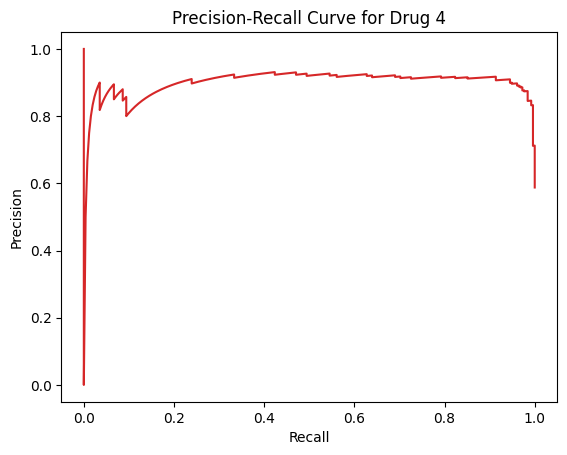

PR-AUC for Drug 4: 0.8984

Epoch 14/20
Training Loss: 0.2037
Validation Loss: 0.2752
Learning Rate: 3.53e-06

Validation Metrics:
----------------------------------------
Precision: 0.8475
Recall: 0.8744
F1 Score: 0.8608
Accuracy: 0.8923
Specificity: 0.9033
Npv: 0.9213

Confusion Matrix Elements:
True Positives: 578
True Negatives: 971
False Positives: 104
False Negatives: 83
----------------------------------------


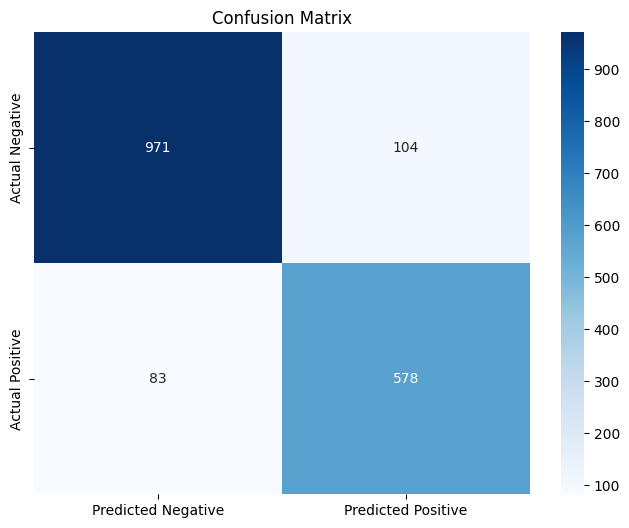

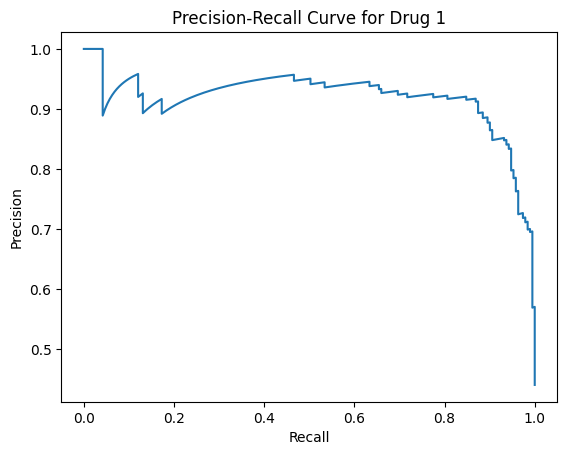

PR-AUC for Drug 1: 0.9180


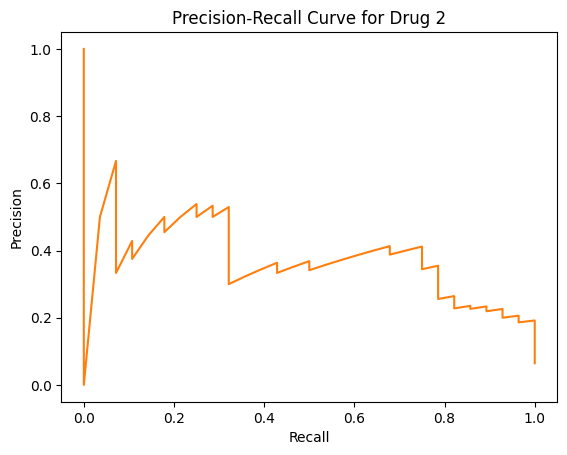

PR-AUC for Drug 2: 0.3644


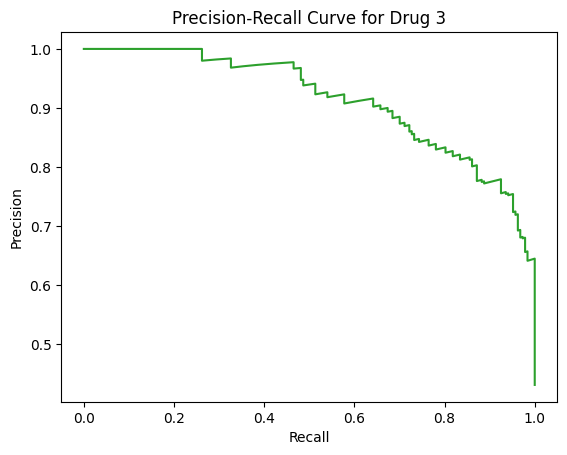

PR-AUC for Drug 3: 0.9136


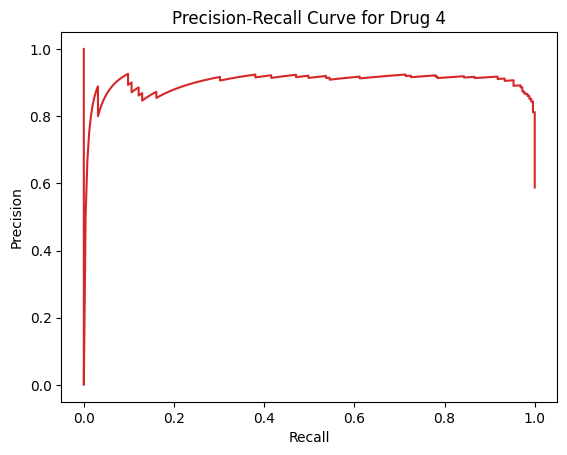

PR-AUC for Drug 4: 0.8991

Epoch 15/20
Training Loss: 0.1942
Validation Loss: 0.2743
Learning Rate: 2.94e-06

Validation Metrics:
----------------------------------------
Precision: 0.8361
Recall: 0.9032
F1 Score: 0.8684
Accuracy: 0.8957
Specificity: 0.8912
Npv: 0.9374

Confusion Matrix Elements:
True Positives: 597
True Negatives: 958
False Positives: 117
False Negatives: 64
----------------------------------------


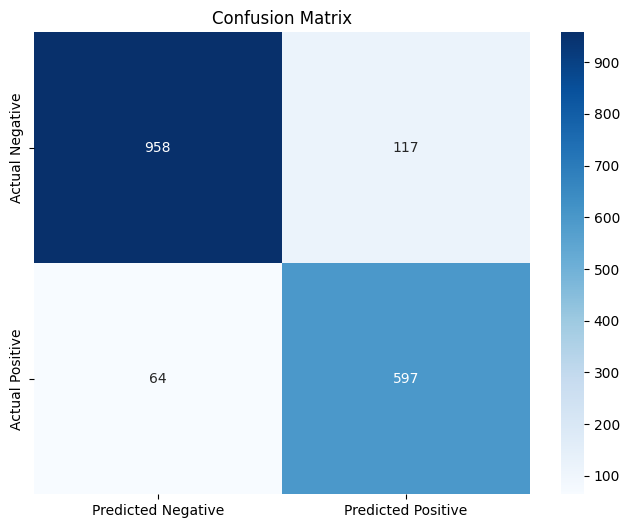

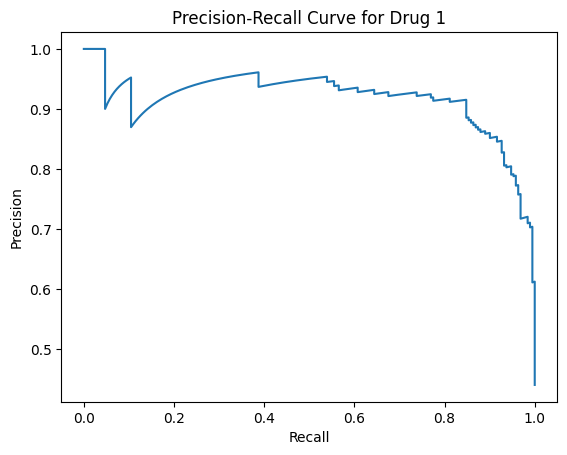

PR-AUC for Drug 1: 0.9170


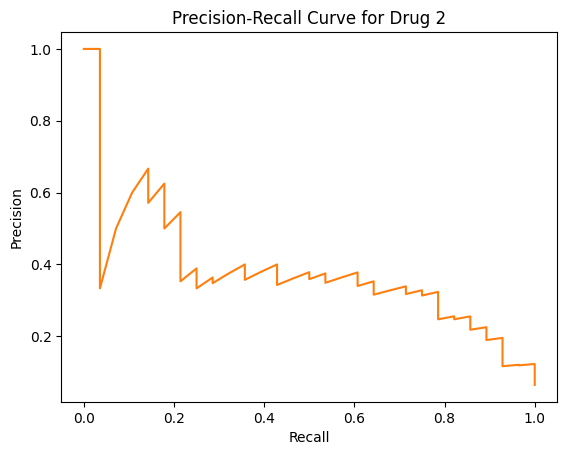

PR-AUC for Drug 2: 0.3772


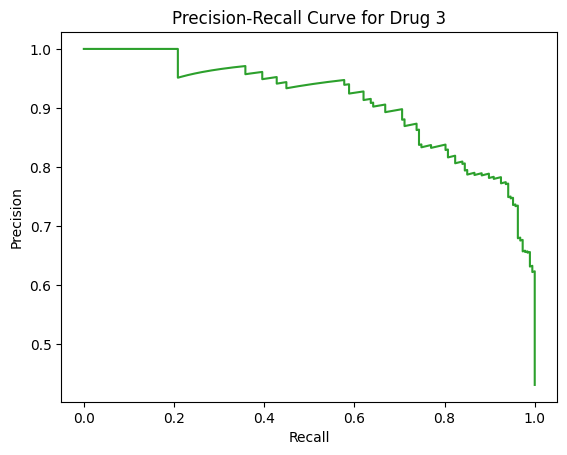

PR-AUC for Drug 3: 0.9094


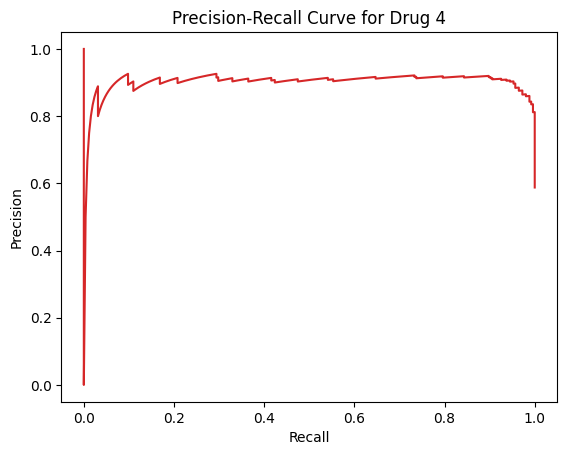

PR-AUC for Drug 4: 0.9002

Epoch 16/20
Training Loss: 0.1860
Validation Loss: 0.2865
Learning Rate: 2.35e-06

Validation Metrics:
----------------------------------------
Precision: 0.8269
Recall: 0.9032
F1 Score: 0.8633
Accuracy: 0.8911
Specificity: 0.8837
Npv: 0.9369

Confusion Matrix Elements:
True Positives: 597
True Negatives: 950
False Positives: 125
False Negatives: 64
----------------------------------------


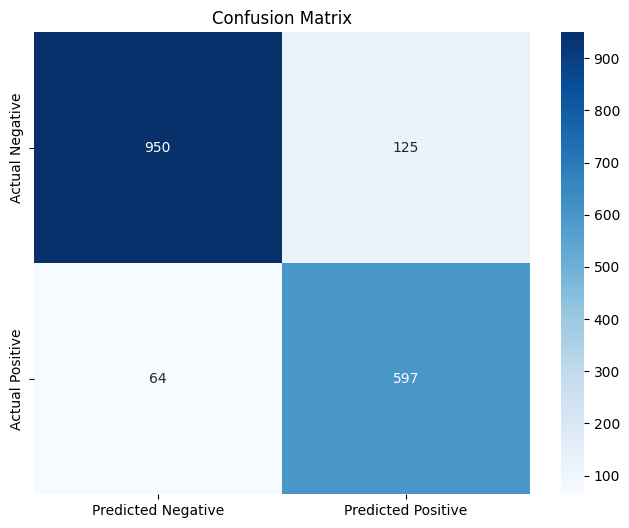

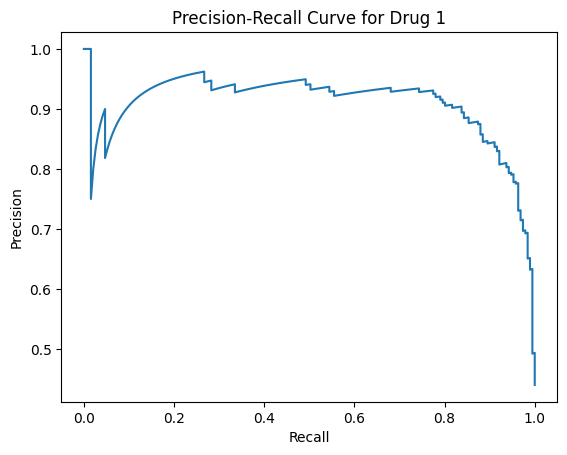

PR-AUC for Drug 1: 0.9073


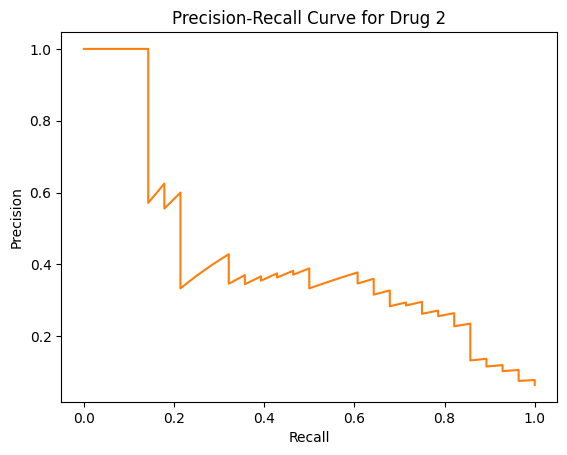

PR-AUC for Drug 2: 0.4169


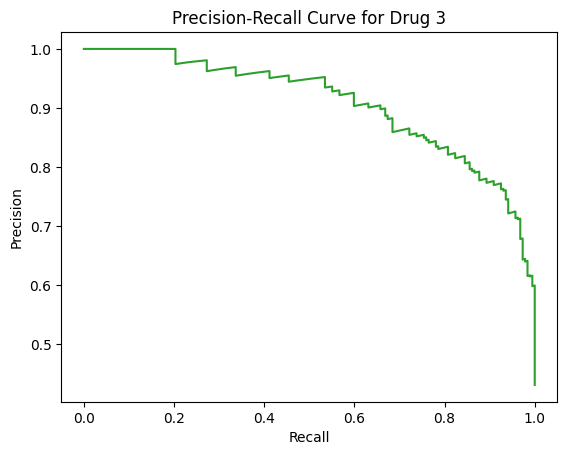

PR-AUC for Drug 3: 0.9081


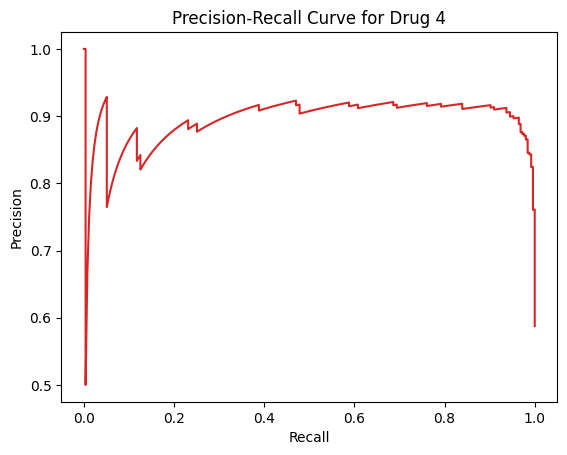

PR-AUC for Drug 4: 0.8949

Epoch 17/20
Training Loss: 0.1816
Validation Loss: 0.2885
Learning Rate: 1.76e-06

Validation Metrics:
----------------------------------------
Precision: 0.8613
Recall: 0.8548
F1 Score: 0.8580
Accuracy: 0.8923
Specificity: 0.9153
Npv: 0.9111

Confusion Matrix Elements:
True Positives: 565
True Negatives: 984
False Positives: 91
False Negatives: 96
----------------------------------------


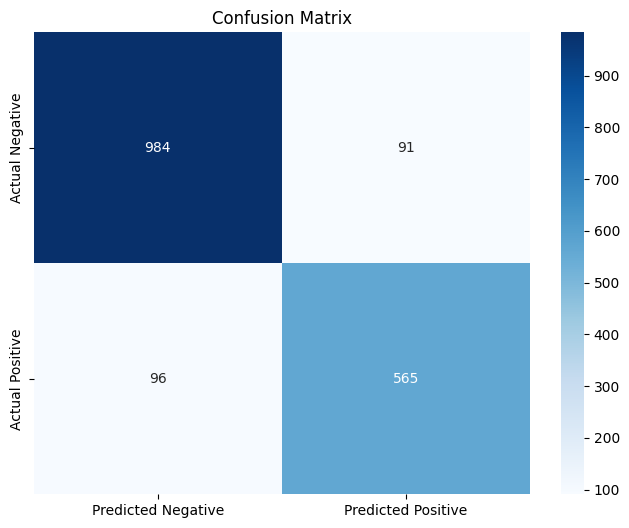

Early stopping triggered at epoch 17


In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Enhanced training configuration
    config = {
        'batch_size': 8,             # Maintained for better gradient estimates
        'learning_rate': 1e-5,        # Slightly reduced for stability
        'num_epochs': 20,             # Increased epochs for deeper convergence
        'warmup_ratio': 0.15,         # Extended warmup to 15%

    # Advanced Class Imbalance Handling
        'class_weights': {
              0: 1.0,                  # Majority class (non-resistance)
              1: 14.0                   # Minority class (resistance) - weighted higher
    },

    # Enhanced Loss Function
        'loss_type': 'focal_loss',
        'focal_gamma': 3.5,           # Refined focal loss parameter
        'focal_alpha': 0.75,          # Maintained alpha for class balance

    # Comprehensive Regularization
        'weight_decay': 0.015,        # Slightly increased
        'dropout_rate': 0.35,         # Increased dropout
        'label_smoothing': 0.15,      # Enhanced label smoothing

    # Advanced Training Optimizations
        'gradient_accumulation_steps': 4,
        'max_grad_norm': 1.2,         # Slight increase in gradient clipping
        'scheduler': 'triangular_with_warmup',  # More dynamic learning rate

    # Sophisticated Early Stopping
        'patience': 7,                # Extended patience
        'monitor_metric': 'recall',   # Maintained focus on recall

    # Enhanced Data Augmentation
        'augmentation': {
            'enable': True,
            'synonym_replacement_prob': 0.4,    # Increased probability
            'backtranslation_prob': 0.3,        # Enhanced probability
            'random_swap_prob': 0.2,            # Increased swap probability
            'noise_injection_prob': 0.2,        # Added noise injection
            'contextual_augment_prob': 0.1      # New contextual augmentation
        },

    # Additional Regularization Techniques
        'l1_regularization': 0.001,   # Added L1 regularization

    # Ensemble Preparation
        'ensemble_strategy': {
            'enable': True,
            'models_to_ensemble': 3,
            'aggregation_method': 'weighted_vote'
        }
    }

    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    model = AutoModelForSequenceClassification.from_pretrained(
        "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        num_labels=4,
        problem_type="multi_label_classification"
    ).to(device)

    # Add dropout for regularization
    model.dropout = torch.nn.Dropout(0.3)

    df = upload_and_process_file()
    sequences, labels = process_resistance_data(df)

    # Stratified split to handle imbalanced data
    X_train, X_val, y_train, y_val = train_test_split(
        sequences, labels,
        test_size=0.2,
        random_state=42
    )

    train_dataset = HIVDrugResistanceDataset(X_train, y_train, tokenizer)
    val_dataset = HIVDrugResistanceDataset(X_val, y_val, tokenizer)

    model, training_stats = train_model(train_dataset, val_dataset, model, device, config)
    return model, training_stats

if __name__ == "__main__":
    main()